In [1]:
import os
import pandas as pd
from pandas import DataFrame

pd.set_option("display.max_columns", 50)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-dark")
sns.set_context("talk", font_scale=0.6)
from scipy.stats.contingency import chi2_contingency
from scipy.stats import normaltest, shapiro
import plotly.express as px
import warnings

warnings.filterwarnings("ignore")

import matplotlib

matplotlib.rcParams.update(
    {"lines.linewidth": 1, "patch.facecolor": "#ebe3df", "axes.facecolor": "#ebe3df"}
)

from sklearn.experimental import enable_iterative_imputer, enable_halving_search_cv
from sklearn.impute import IterativeImputer
from sklearn.model_selection import (
    train_test_split,
    KFold,
    StratifiedShuffleSplit,
    StratifiedKFold,
    GridSearchCV,
    cross_val_score,
    HalvingGridSearchCV,
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.preprocessing import (
    LabelEncoder,
    OneHotEncoder,
    StandardScaler,
    MinMaxScaler,
    FunctionTransformer,
    OrdinalEncoder,
)
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.decomposition import PCA
from sklearn import ensemble
from sklearn.ensemble import (
    BaggingClassifier,
    RandomForestClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
)
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.compose import make_column_selector, ColumnTransformer
from imblearn.over_sampling import (
    KMeansSMOTE,
    ADASYN,
    RandomOverSampler,
    SMOTE,
    SVMSMOTE,
)
from tqdm import tqdm

<ipython-input-1-3b25493c1875>:10: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-dark")


In [3]:
import pandas as pd

In [7]:
df = pd.read_csv("/content/sample_data/WA_Fn-UseC_-Telco-Customer-Churn.csv")
df.head(4)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No


In [8]:
n_rows, n_columns = df.shape
print(f"Number of columns: {n_columns} columns\nNumber of rws: {n_rows} rows")

Number of columns: 21 columns
Number of rws: 7043 rows


In [9]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [10]:
total_charge = df["TotalCharges"]
missing = total_charge[~total_charge.str.replace(".", "").str.isdigit()]
print("Number of missing total charge: ", len(missing))
missing.head()

Number of missing total charge:  11


488      
753      
936      
1082     
1340     
Name: TotalCharges, dtype: object

In [11]:
# Coverting the total charge column to numeric
df["TotalCharges"] = df["TotalCharges"].apply(pd.to_numeric, errors="coerce")

In [12]:
styled_df = (
    df.describe()
    .drop("count", axis=0)
    .style.background_gradient(axis=0, cmap="magma")
    .set_properties(**{"text-align": "center"})
    .set_table_styles([{"selector": "th", "props": [("background-color", "k")]}])
    .set_caption("Summary Statistics")
)

styled_df

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


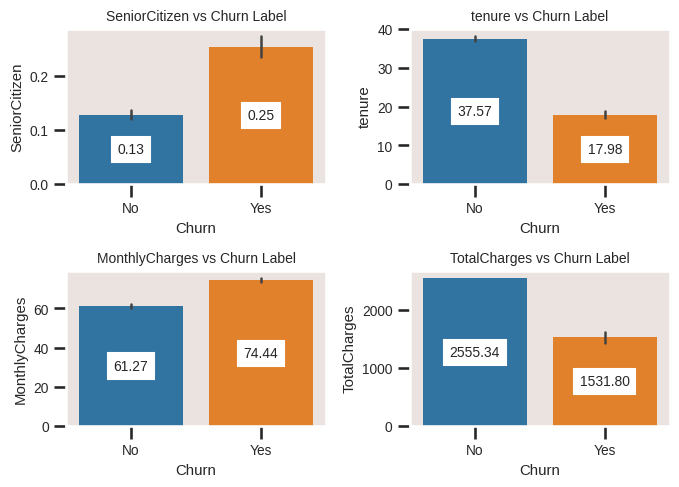

In [13]:
numeric_columns = df.select_dtypes(include=["int64", "float64"]).columns

fig, axes = plt.subplots(2, 2, figsize=(7, 5))
axes = axes.flatten()
for i, column in enumerate(tqdm(numeric_columns)):
    ax = axes[i]
    sns.barplot(data=df, x="Churn", y=column, ax=ax, estimator=np.mean)
    ax.set_title(f"{column} vs Churn Label", fontsize=10)

    for k in ax.containers:
        ax.bar_label(
            k, fontsize=10, label_type="center", backgroundcolor="w", fmt="%.2f"
        )
plt.tight_layout()
plt.show()

In [15]:
def get_unique(dataframe: DataFrame):
    cat_cols = dataframe.select_dtypes(exclude="number")
    uni_values = []
    counts = []
    pct = []

    for col in cat_cols.columns:
        uni_value, count = np.unique(
            np.array(cat_cols[col], dtype=str), return_counts=True
        )
        uni_values.append(uni_value)
        counts.append(count)
        pct.append(np.round(count / count.sum() * 100, 2))

    return pd.DataFrame(
        {
            "dtype": cat_cols.dtypes,
            "unique_values": uni_values,
            "counts": [len(val) for val in uni_values],
            "values_count": counts,
            "pct": pct,
        }
    )

In [16]:
get_unique(df)

,dtype,unique_values,counts,values_count,pct
customerID,object,"[0002-ORFBO, 0003-MKNFE, 0004-TLHLJ, 0011-IGKF...",7043,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0..."
gender,object,"[Female, Male]",2,"[3488, 3555]","[49.52, 50.48]"
Partner,object,"[No, Yes]",2,"[3641, 3402]","[51.7, 48.3]"
Dependents,object,"[No, Yes]",2,"[4933, 2110]","[70.04, 29.96]"
PhoneService,object,"[No, Yes]",2,"[682, 6361]","[9.68, 90.32]"
MultipleLines,object,"[No, No phone service, Yes]",3,"[3390, 682, 2971]","[48.13, 9.68, 42.18]"
InternetService,object,"[DSL, Fiber optic, No]",3,"[2421, 3096, 1526]","[34.37, 43.96, 21.67]"
OnlineSecurity,object,"[No, No internet service, Yes]",3,"[3498, 1526, 2019]","[49.67, 21.67, 28.67]"
OnlineBackup,object,"[No, No internet service, Yes]",3,"[3088, 1526, 2429]","[43.84, 21.67, 34.49]"
DeviceProtection,object,"[No, No internet service, Yes]",3,"[3095, 1526, 2422]","[43.94, 21.67, 34.39]"


In [17]:
cat_cols = df.dtypes[df.dtypes == "O"].index
cat_cols = cat_cols.drop(["customerID", "Churn"], errors="ignore")

fig, axes = plt.subplots(4, 4, figsize=(20, 18), dpi=500)
axes = axes.flatten()
fig.suptitle("Churn by Category", fontsize=25, fontweight="bold", y=1)

for i, col in enumerate(cat_cols):
    ax = axes[i]
    sns.countplot(data=df, x=col, hue="Churn", ax=ax, palette="Set2")
    ax.legend(frameon=True, facecolor="inherit", shadow=True)
    ax.set_title(f"Churn by {col}", fontsize=13)
    plt.tight_layout(pad=0.6)

    for i in ax.containers:
        ax.bar_label(i, fontsize=13)
plt.delaxes(ax=axes[-1])
plt.tight_layout()

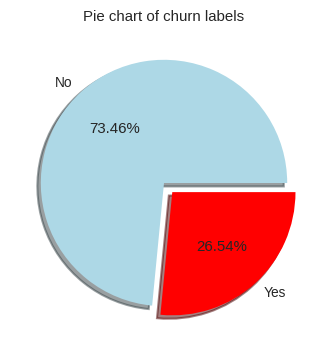

In [18]:
# Getting a sense of the percentage of churn labels
churn_label_count = df["Churn"].value_counts()
fig = plt.figure(figsize=(7, 4), dpi=100)
plt.pie(
    churn_label_count,
    autopct="%.2f%%",
    labels=churn_label_count.index,
    colors=["lightblue", "red"],
    explode=[0, 0.1],
    shadow=True,
)
plt.title("Pie chart of churn labels")
plt.show()

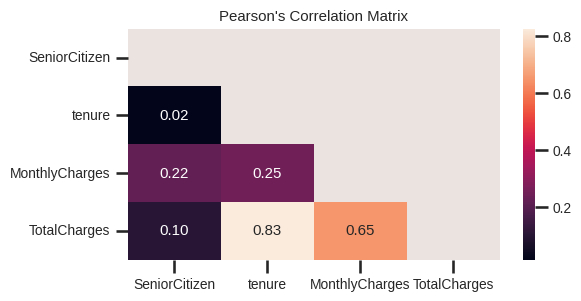

In [19]:
corr = df.corr(numeric_only=True)

mask = np.triu(np.ones_like(corr, dtype=bool))

plt.figure(figsize=(6, 3))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", linecolor="c")
plt.title("Pearson's Correlation Matrix")
plt.show()

In [20]:
df.drop(
    columns=["customerID"],
    inplace=True,
    errors="ignore",
)

In [21]:
df.isna().sum()

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [22]:
imputer = IterativeImputer()
df["TotalCharges"] = imputer.fit_transform(df[["TotalCharges"]])

100%|██████████| 4/4 [00:01<00:00,  3.51it/s]


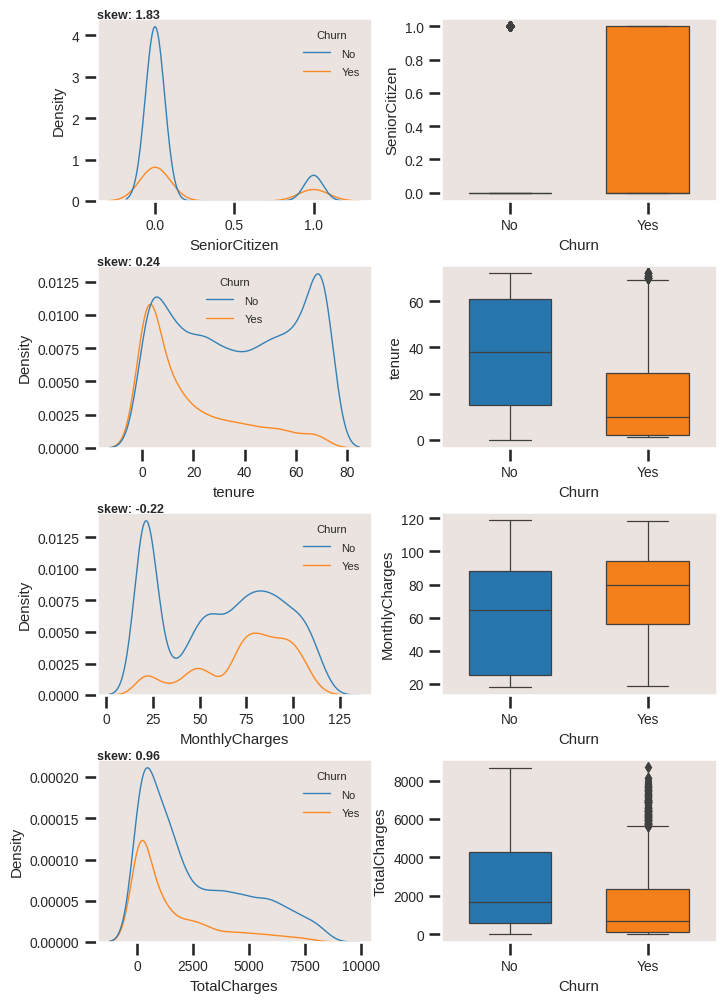

In [23]:
# Before applying log
number_columns = df.select_dtypes("number")

skewness_before_log = df[number_columns.columns].skew()
fig, axes = plt.subplots(
    nrows=4,
    ncols=2,
    figsize=(8, 12),
    gridspec_kw={"hspace": 0.35, "wspace": 0.25, "width_ratios": [0.3, 0.3]},
)
axes = axes.flatten()
i = 0
for column in tqdm(number_columns.columns):
    ax = axes[i]
    sns.kdeplot(
        data=df, x=column, hue="Churn", ax=ax, fill=False, alpha=0.9, legend=True
    )
    skewness = skewness_before_log[column]
    ax.text(
        ax.get_xlim()[0],
        ax.get_ylim()[-1],
        f"skew: {skewness:.2f}",
        size=9,
        weight="bold",
    )
    legend = ax.get_legend()
    plt.setp(legend.get_title(), fontsize=8)
    for text in legend.get_texts():
        text.set_fontsize(8)

    ax = axes[i + 1]
    sns.boxplot(
        data=df,
        x="Churn",
        y=column,
        ax=ax,
        width=0.6,
        saturation=0.9,
        linewidth=0.9,
    )
    i += 2

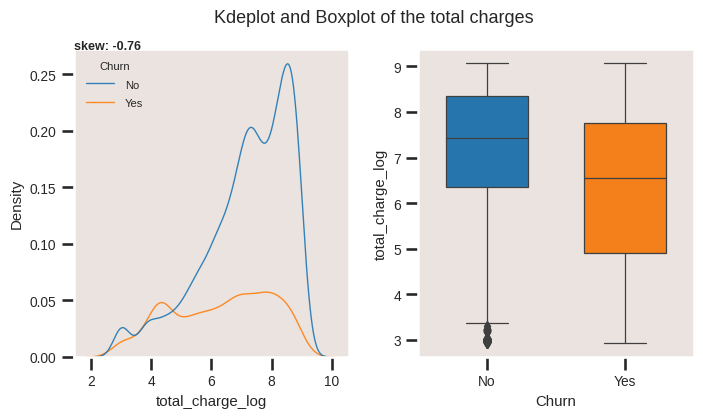

In [24]:
# After applying log
fig, axes = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(8, 4),
    gridspec_kw={"hspace": 0.35, "wspace": 0.25, "width_ratios": [0.3, 0.3]},
)

axes = axes.flatten()

df_copy = df.copy()
df_copy["total_charge_log"] = df_copy["TotalCharges"].apply(np.log)
skewness = df_copy["total_charge_log"].skew()

ax = axes[0]
sns.kdeplot(
    data=df_copy, x="total_charge_log", hue="Churn", ax=ax, fill=False, alpha=0.9
)
ax.text(
    ax.get_xlim()[0], ax.get_ylim()[-1], f"skew: {skewness:.2f}", size=9, weight="bold"
)
legend = ax.get_legend()
plt.setp(legend.get_title(), fontsize=8)
for text in legend.get_texts():
    text.set_fontsize(8)

ax = axes[1]
sns.boxplot(
    data=df_copy,
    x="Churn",
    y="total_charge_log",
    ax=ax,
    width=0.6,
    saturation=0.9,
    linewidth=0.9,
)
plt.suptitle("Kdeplot and Boxplot of the total charges")
plt.show()

In [25]:
unique_counts = df.select_dtypes("O").nunique()
binary_columns = unique_counts[unique_counts == 2].index.drop("Churn").tolist()
categorical_columns = unique_counts[unique_counts > 2].index.tolist()
target_column = "Churn"

In [26]:
X = df.drop(target_column, axis=1)
y = df[target_column]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)
X_train.head(2)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6661,Female,0,Yes,Yes,72,No,No phone service,DSL,No,Yes,No,Yes,Yes,Yes,Two year,No,Credit card (automatic),53.65,3784.0
4811,Female,0,No,No,4,Yes,No,DSL,No,No,No,No,No,No,Month-to-month,Yes,Mailed check,46.00,193.6


In [27]:
transformer = ColumnTransformer(
    [
        ("scaler", StandardScaler(), ["MonthlyCharges", "TotalCharges", "tenure"]),
        ("binary_encoder", OrdinalEncoder(), binary_columns),
        ("ohe", OneHotEncoder(drop="first"), categorical_columns),
    ],
    remainder="passthrough",
)

transformer.fit(X_train)
columns = transformer.get_feature_names_out()
columns = list(map(lambda x: str(x).split("__")[-1], columns))

X_train = pd.DataFrame(transformer.transform(X_train), columns=columns)
X_test = pd.DataFrame(transformer.transform(X_test), columns=columns)

In [28]:
label_encoder = LabelEncoder()
label_encoder.fit(y_train)
y_train = label_encoder.transform(y_train)
y_test = label_encoder.transform(y_test)

Modeling with default hyparameters and imbalanced class

In [29]:
classifiers = {
    "svc": SVC(),
    "rfc": ensemble.RandomForestClassifier(),
    "gb": ensemble.GradientBoostingClassifier(),
}

In [30]:
def evaluate_model(y_true, y_pred):
    all_metrics = {
        "acc": metrics.accuracy_score(y_true, y_pred),
        "precision": metrics.precision_score(y_true, y_pred),
        "recall": metrics.recall_score(y_true, y_pred),
        "f1": metrics.f1_score(y_true, y_pred),
    }
    return all_metrics

In [31]:
model_performances = []

for label, model in tqdm(classifiers.items()):
    n_splits = 3
    kf = StratifiedKFold(shuffle=True, n_splits=n_splits, random_state=42)
    performaces = np.zeros((n_splits, 4))

    X_values = X_train.values
    i = 0
    for train_idx, test_idx in kf.split(X_values, y_train):
        train_set = X_values[train_idx], y_train[train_idx]
        test_set = X_values[test_idx], y_train[test_idx]
        model.fit(*train_set)
        y_pred = model.predict(test_set[0])
        perf = evaluate_model(test_set[1], y_pred)
        performaces[i, :] = list(perf.values())
        i += 1
    model_performances.append(
        pd.Series(np.mean(performaces, axis=0), index=list(perf.keys()), name=label)
    )

100%|██████████| 3/3 [00:06<00:00,  2.25s/it]


In [32]:
performaces_df = pd.concat(model_performances, axis=1)

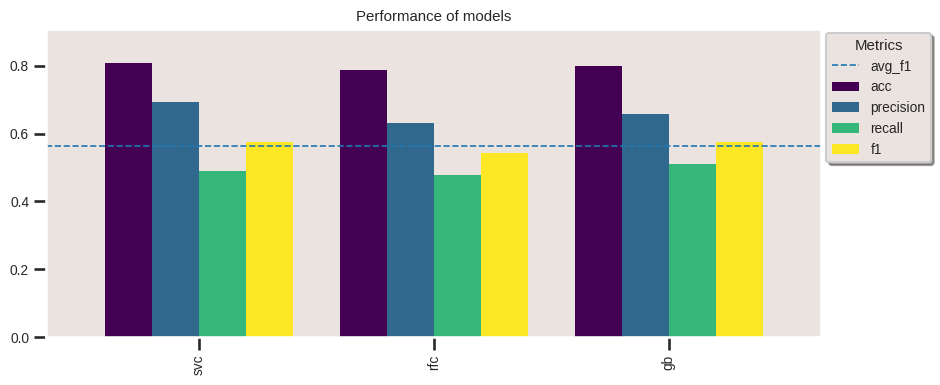

In [33]:
avg_f1 = performaces_df.loc["f1"].mean()
fig, ax = plt.subplots()
performaces_df.T.plot(
    kind="bar",
    title="Performance of models",
    colormap=plt.cm.viridis,
    width=0.8,
    figsize=(10, 4),
    ax=ax,
)
ylim = ax.get_ylim()
ax.set(ylim=(0, ylim[-1] + 0.06))
ax.hlines(avg_f1, *ax.get_xlim(), ls="--", label="avg_f1", lw=1.2)
ax.legend(
    loc="best",
    shadow=True,
    frameon=True,
    facecolor="inherit",
    bbox_to_anchor=(0.15, 0.01, 1, 1),
    title="Metrics",
)
plt.show()

Investigating Feature Importance

In [34]:
svc_params = dict(
    C=0.8,
    kernel="rbf",
    degree=4,
    gamma="auto",
    shrinking=True,
    class_weight="balanced",
    probability=True,
    tol=0.001,
    break_ties=False,
    random_state=42,
)

rfc_params = dict(
    n_estimators=500,
    criterion="gini",
    max_depth=6,
    min_samples_split=5,
    n_jobs=-1,
    random_state=42,
    class_weight="balanced",
    max_samples=0.6,
)

gb_params = dict(
    loss="log_loss",
    n_estimators=500,
    subsample=0.6,
    criterion="friedman_mse",
    min_samples_split=5,
    max_depth=3,
    random_state=42,
    max_features=0.6,
    validation_fraction=0.1,
)

In [35]:
class Classifiers:
    def __init__(self):
        self.models = self._build_models()

    def _build_models(self):
        models = {
            "svc": SVC(**svc_params),
            "rfc": ensemble.RandomForestClassifier(**rfc_params),
            "gb": ensemble.GradientBoostingClassifier(**gb_params),
        }
        return models

In [38]:
class FeatureImportanceChecker(Classifiers):
    def __init__(self, n_splits=3, random_state=42):
        super().__init__()
        self.n_splits = n_splits
        self.random_state = random_state

    def get_feature_importances(self, X, y):
        results = {}

        for model_name, model in tqdm(self.models.items()):
            feature_importances = list()
            f1 = list()
            X_values = np.asarray(X)

            kf = StratifiedKFold(
                n_splits=self.n_splits, shuffle=True, random_state=self.random_state
            )

            for train_idx, test_idx in kf.split(X_values, y):
                train_set = X_values[train_idx, :], y[train_idx]
                test_set = X_values[test_idx, :], y[test_idx]

                if isinstance(
                    model,
                    (
                        RandomForestClassifier,
                        GradientBoostingClassifier,
                    ),
                ):
                    model.fit(*train_set)

                    if hasattr(model, "feature_importances_"):
                        FI = model.feature_importances_
                        pred = model.predict(test_set[0])

                    else:
                        FI = np.nan
                        print(f"{model_name} has no attribute feature_importances_.")
                        pred = model.predict(test_set[0])

                elif isinstance(model, (SVC)):
                    model.fit(*train_set)
                    if hasattr(model, "coef_"):
                        FI = model.coef_
                        pred = model.predict(test_set[0])

                    else:
                        FI = np.nan
                        print(f"{model_name} has no attribute coef_")
                        pred = model.predict(test_set[0])

                else:
                  FI = np.nan
                  model.fit(*train_set)
                  print(f"{model_name} has no attribute feature_importances_.")
                  pred = model.predict(test_set[0])

                feature_importances.append(np.abs(FI))
                f1.append(metrics.f1_score(test_set[1], pred))

            results[model_name] = {
                "F_importances": np.mean(feature_importances, axis=0),
                "f1_scores": np.mean(f1),
            }
        return results

    @classmethod
    def permutation_FI(cls, model, X_train, y_train, X_test, y_test):
        losses = []
        original = None
        for col in X_train.columns:
            original = X_train[col].copy()
            X_train[col] = np.random.permutation(X_train[col])
            model.fit(X_train, y_train)
            pred = model.predict(X_test)
            loss = metrics.log_loss(y_test, pred)
            losses.append(loss)
            X_train[col] = original
        return losses


In [39]:
FI_checker = FeatureImportanceChecker(n_splits=3, random_state=42)
feature_importance = FI_checker.get_feature_importances(X_train, y_train)

  0%|          | 0/3 [00:00<?, ?it/s]

svc has no attribute coef_
svc has no attribute coef_
svc has no attribute coef_


100%|██████████| 3/3 [00:28<00:00,  9.50s/it]


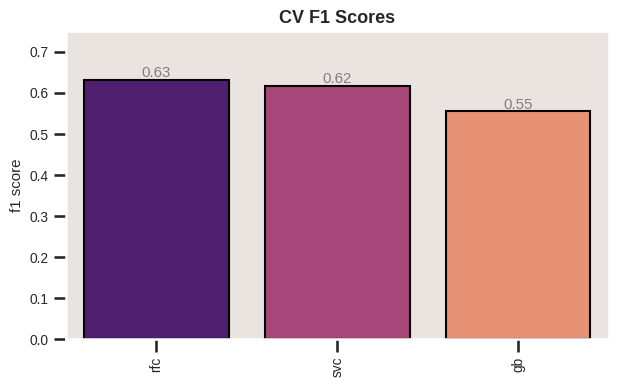

In [40]:
f1_dict = {model: result["f1_scores"] for model, result in feature_importance.items()}
f1_series = pd.Series(f1_dict, name="f1 score")
f1_series.sort_values(ascending=False, inplace=True)

fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(x=f1_series.index, y=f1_series, ax=ax, palette="magma", edgecolor="k")
ax.set(ylim=(0, 0.75))
ax.set_title("CV F1 Scores", weight="bold", size=13)
for i in ax.containers:
    ax.bar_label(i, fmt="%.2f", color="gray")
plt.xticks(rotation=90)
plt.show()


In [41]:
F_importance = {
    model: result["F_importances"].ravel()
    for model, result in feature_importance.items()
    if type(result["F_importances"]) == np.ndarray
}
F_importance_df = pd.DataFrame(F_importance, index=X_train.columns)

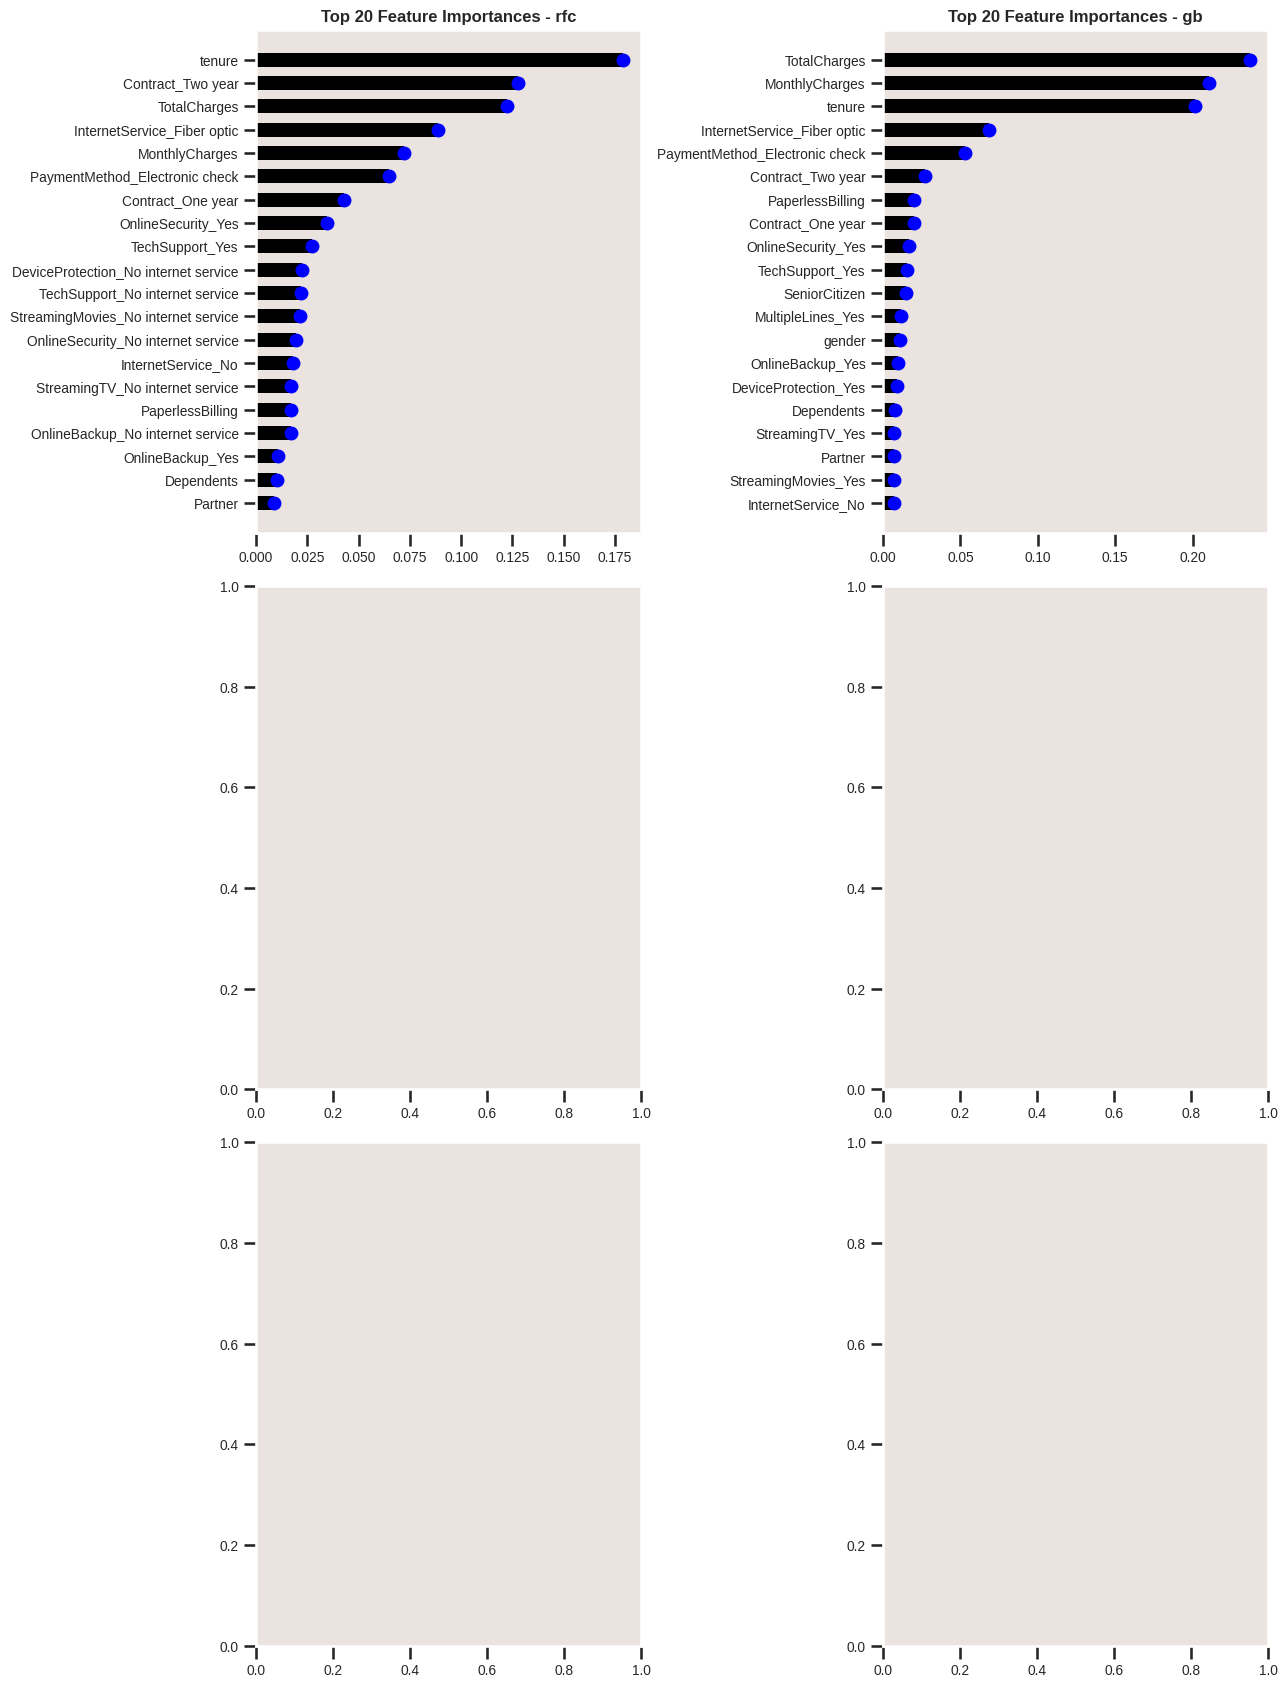

In [42]:
top_features = []

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 17))
axes = axes.flatten()
for i, col in enumerate(F_importance_df.columns):
    series = F_importance_df[col].sort_values(ascending=False)[:20]
    top_features.append(series.index[:10])
    axes[i].plot(series.values, series.index, marker="o", ls="", color="blue")
    axes[i].barh(width=series.values, y=series.index, height=0.6, color="k")
    axes[i].invert_yaxis()
    axes[i].set_title(f"Top 20 Feature Importances - {col}", size=12, weight="bold")
plt.tight_layout()

In [44]:
import itertools

most_important_features = set(itertools.chain.from_iterable(top_features))
print(f"Top {len(most_important_features)} features")
X_train1 = X_train[list(most_important_features)]
X_test1 = X_test[list(most_important_features)]

Top 11 features


In [46]:
class ClassBalancingModelTester(Classifiers):
    def __init__(self, X, y, n_splits, random_state=42):
        super().__init__()
        self.X = np.asarray(X)
        self.y = np.asarray(y)
        self.n_splits = n_splits
        self.random_state = random_state

        self.sampling = {
            "ros": RandomOverSampler(random_state=self.random_state),
            "rus": RandomUnderSampler(random_state=self.random_state),
            "smote-enn": SMOTEENN(random_state=self.random_state),
            "smote": SMOTE(random_state=self.random_state),
            "smote-tomek": SMOTETomek(random_state=self.random_state),
            "adasyn": ADASYN(random_state=self.random_state),
            "kmeans-smote": KMeansSMOTE(random_state=self.random_state),
            "svm-smote": SVMSMOTE(random_state=self.random_state),
        }

    def test_models_with_balancing(self):
        f1_scores = {}

        for name, model in tqdm(self.models.items()):
            for sampler_name, sampler in self.sampling.items():
                X_resampled, y_resampled = sampler.fit_resample(self.X, self.y)
                result = np.zeros(self.n_splits)
                kf = StratifiedKFold(
                    shuffle=True, n_splits=self.n_splits, random_state=self.random_state
                )
                i = 0
                for train_idx, test_idx in kf.split(X_resampled, y_resampled):
                    train_set = X_resampled[train_idx], y_resampled[train_idx]
                    # test_set = X_resampled[test_idx], y_resampled[test_idx]
                    test_set = X_test1, y_test
                    model.fit(*train_set)
                    result[i] = metrics.f1_score(
                        test_set[1], model.predict(test_set[0])
                    )
                    i += 1
                result_key = f"{name}_with_{sampler_name}"
                f1_scores[result_key] = np.mean(result)
        return f1_scores

In [47]:
model_tester = ClassBalancingModelTester(X_train1, y_train, 3)
results = model_tester.test_models_with_balancing()

100%|██████████| 3/3 [03:34<00:00, 71.57s/it]


In [48]:
results1 = sorted(results.items(), key=lambda x: x[1], reverse=True)
results1 = dict(results1)

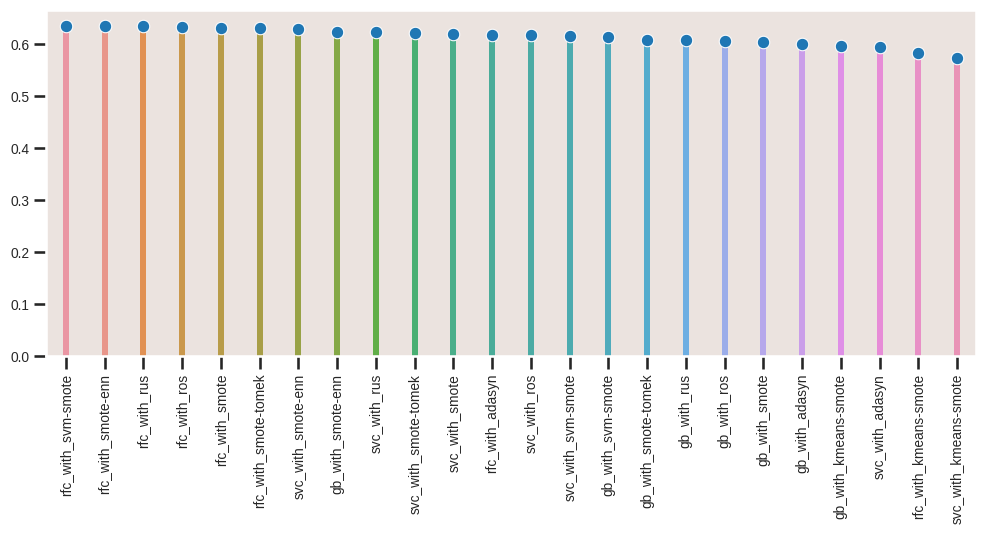

In [49]:
fig, ax = plt.subplots(figsize=(12, 4.5))
sns.lineplot(
    x=list(results1.keys())[:50],
    y=list(results1.values())[:50],
    marker="o",
    ls="",
    ax=ax,
)
sns.barplot(
    x=list(results1.keys())[:50], y=list(results1.values())[:50], width=0.15, ax=ax
)
plt.xticks(rotation=90)
plt.show()

In [50]:
samplers = pd.Series(results, name="f1_score")
samplers = samplers.reset_index()
samplers["sampler"] = samplers["index"].apply(lambda x: x.split("_")[-1])
samplers["model"] = samplers["index"].apply(lambda x: x.split("_")[0])

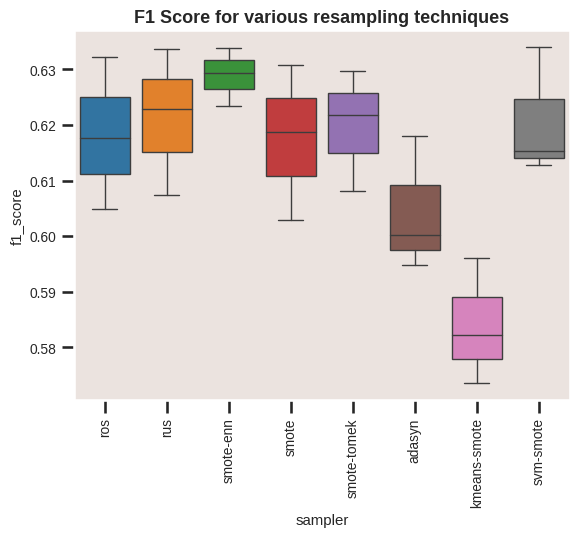

In [51]:
ax = plt.axes()
sns.boxplot(data=samplers, y="f1_score", x="sampler", ax=ax)
ax.set_title("F1 Score for various resampling techniques", size=13, weight="bold")
plt.xticks(rotation=90)
plt.show()

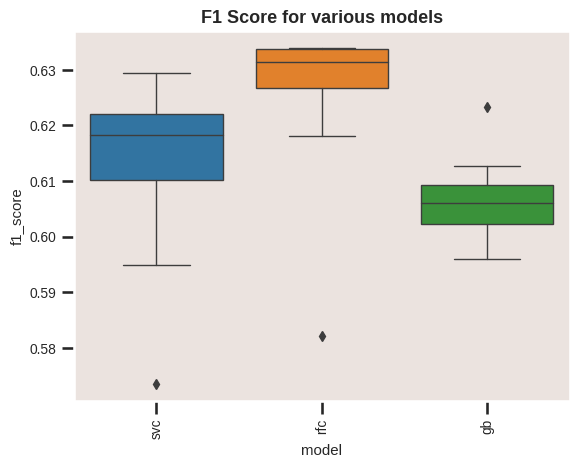

In [52]:
ax = plt.axes()
sns.boxplot(data=samplers, y="f1_score", x="model", ax=ax)
ax.set_title("F1 Score for various models", size=13, weight="bold")
plt.xticks(rotation=90)
plt.show()

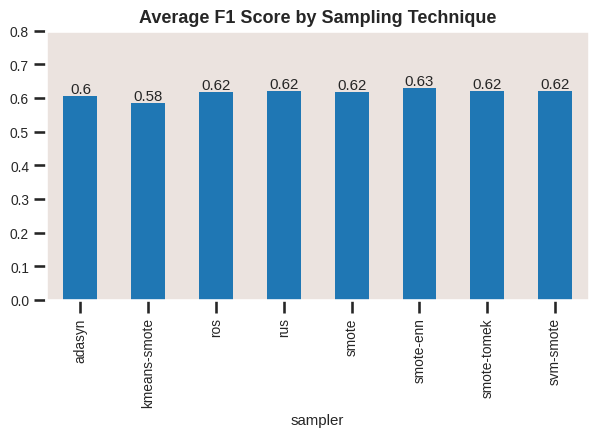

In [53]:
by_sampler = samplers.groupby("sampler")["f1_score"].agg(["mean", "std"])

ax = plt.axes()
by_sampler.plot(
    kind="bar",
    y="mean",
    # yerr = "std",
    title="Average F1 Score by Sampling Technique",
    ylim=(0, 0.8),
    figsize=(7, 3.5),
    legend=False,
    ax=ax,
)
for i in ax.containers:
    ax.bar_label(i, fmt="%.2g")
plt.setp(ax.title, weight="bold", size=13)
plt.show()

In [55]:
class EvaluateModels(Classifiers):
    def __init__(self):
        super().__init__()

    def _resample(self, X, y, sampler=RandomOverSampler(sampling_strategy="all")):
        X_resampled, y_resampled = sampler.fit_resample(X, y)
        shuffled = np.random.permutation(np.c_[X_resampled, y_resampled])
        X = shuffled[:, :-1]
        y = shuffled[:, -1]
        return X, y

    def _fit(self, model, X, y, resample=True):
        if resample:
            self.X, self.y = self._resample(X, y)
            fitted_model = model.fit(self.X, self.y)
        else:
            fitted_model = model.fit(np.asarray(X), np.asarray(y))
        return fitted_model

    def _predict(self, model, X):
        pred = model.predict(X)
        return pred

    def _fit_predict(self, model, x_train, y_train, x_test):
        model = self._fit(model, x_train, y_train, resample=True)
        pred = self._predict(model, X=x_test)
        return pred

    def _plot_confusion_matrix(self, y_true, y_pred, ax):
        cm = metrics.confusion_matrix(y_true, y_pred)
        # print("\n",metrics.classification_report(y_true, y_pred, target_names=label_encoder.classes_))
        f1 = metrics.f1_score(y_true, y_pred)
        cm_norm = cm / cm.sum(axis=1).reshape((-1, 1))
        annot = np.array(
            [f"{n}\n{pct:.2%}" for n, pct in zip(cm.ravel(), cm_norm.ravel())]
        ).reshape(cm.shape)
        sns.heatmap(
            cm,
            annot=annot,
            ax=ax,
            fmt="",
            cmap="magma",
            cbar=False,
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
        )
        ax.set(ylabel="Actual", xlabel="Predicted")
        ax.set_title(f"Confusion Matrix - F1: {f1:.1%}")

    def plot_decision_boundry(self, model, X, y, ax):
        pca = PCA(n_components=2)
        X, y = self._resample(X, y)
        X_pca = pca.fit_transform(X)
        model = self._fit(model, X_pca, y, resample=False)

        xmin = X_pca[:, 0].min()
        xmax = X_pca[:, 0].max()
        ymin = X_pca[:, 1].min()
        ymax = X_pca[:, 1].max()

        xx = np.linspace(xmin, xmax, 50)
        yy = np.linspace(ymin, ymax, 50)

        XX, YY = np.meshgrid(xx, yy)
        Z = np.c_[XX.ravel(), YY.ravel()]
        Z = model.predict(Z).reshape(XX.shape)

        ax.contourf(XX, YY, Z, alpha=0.3, cmap=plt.cm.cividis)
        index = np.random.randint(0, len(X_pca), 1000)
        handle = sns.scatterplot(
            x=X_pca[index, 0],
            y=X_pca[index, 1],
            style=y[index],
            hue=y[index],
            markers=["o", "^"],
            ax=ax,
        )
        ax.set_title(
            f"Decision boundry - Explained variation: {sum(pca.explained_variance_ratio_):.2%}"
        )
        ax.set(ylabel="PC_1", xlabel="PC_2")
        ax.legend(frameon=True)

    def plot_roc_curve(self, model, X, y, ax):
        proba = model.predict_proba(X)[:, -1]
        auc = metrics.roc_auc_score(y, proba)
        fpr, tpr, _ = metrics.roc_curve(y, proba)

        sns.lineplot(x=fpr, y=tpr, lw=0.5, ax=ax)

        ax.plot(fpr, fpr, lw=0.5, ls="--")
        ax.fill_between(fpr, tpr, fpr, alpha=0.08, color="y")
        ax.set(ylabel="fpr", xlabel="tpr", title="ROC curve")
        ax.text(
            0.4,
            0.61,
            f"auc: {auc:.2f}",
            fontsize=10,
            ha="center",
            va="center",
            rotation=32,
            backgroundcolor="w",
        )

    def evaluate_model(self, model_name, x_train, y_train, x_test, y_true):
        model = self.models[model_name]
        # pred = self._fit_predict(model, X_train1, y_train, X_test1.values, label="test")
        if hasattr(model, "predict_proba"):
            fig = plt.figure(constrained_layout=False, figsize=(9, 6))

            gs = fig.add_gridspec(nrows=2, ncols=2, width_ratios=[0.5, 0.3])
            ax1 = fig.add_subplot(gs[:, 0])
            ax2 = fig.add_subplot(gs[:-1, -1])
            ax3 = fig.add_subplot(gs[-1, -1])
            labelsize = 8
            ax1.labelsize = labelsize
            ax2.labelsize = labelsize
            ax3.labelsize = labelsize

            self.plot_decision_boundry(model, x_train, y_train, ax=ax1)

            model = self._fit(model, x_train, y_train, resample=True)
            pred = self._predict(model, x_test.values)
            self._plot_confusion_matrix(y_true, pred, ax=ax2)
            self.plot_roc_curve(model, x_test, y_true, ax=ax3)
            fig.suptitle(f"Evaluation {model_name}", size=14, weight="bold")
            plt.tight_layout()

        else:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 4))
            self.plot_decision_boundry(model, x_train, y_train, ax=ax1)
            pred = self._predict(model, x_test.values)
            self._plot_confusion_matrix(y_true, pred, ax=ax2)
            fig.suptitle(f"Evaluation {model_name}", size=14, weight="bold")
            plt.tight_layout()
        plt.show()

    def evaluate_all(self, x_train, y_train, x_test, y_true):
        for model_name in tqdm(self.models):
            self.evaluate_model(model_name, x_train, y_train, x_test, y_true)

  0%|          | 0/3 [00:00<?, ?it/s]

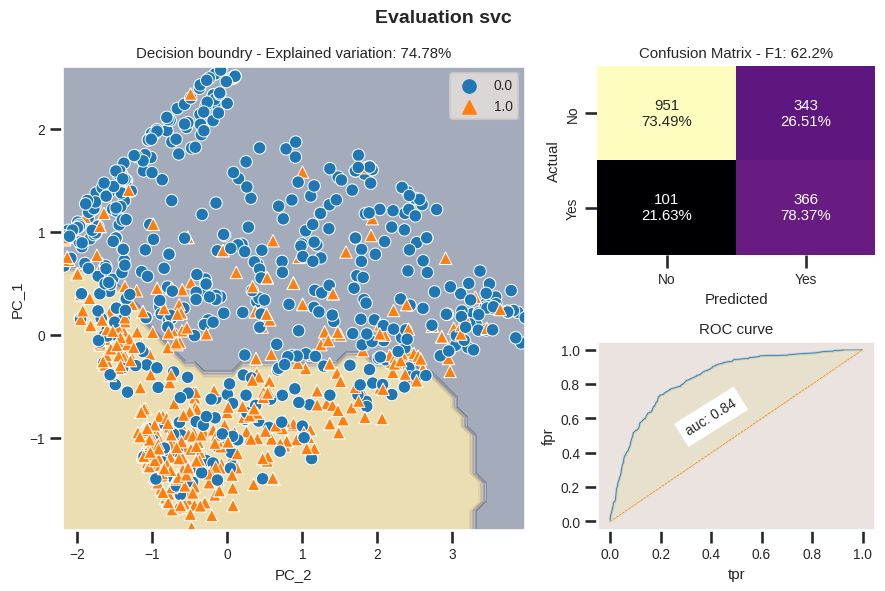

 33%|███▎      | 1/3 [00:34<01:08, 34.42s/it]

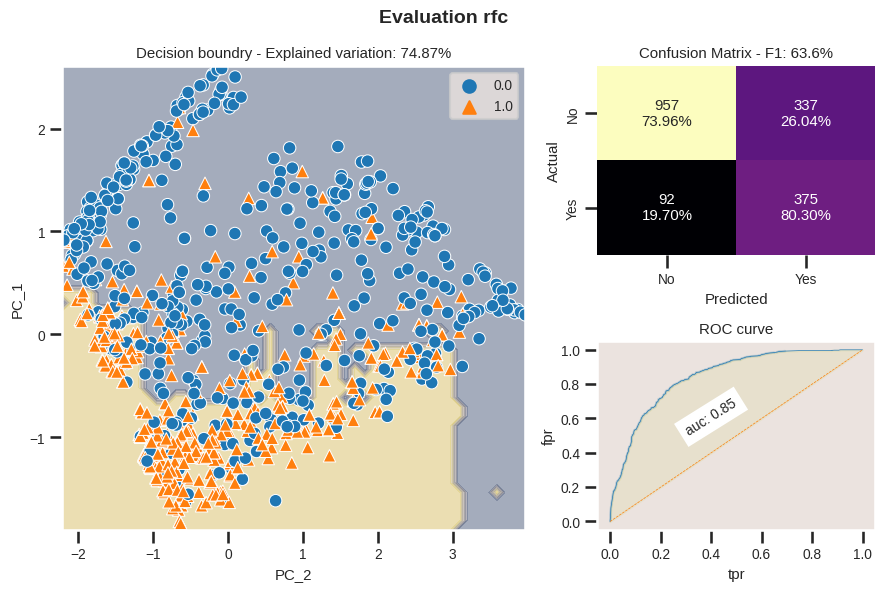

 67%|██████▋   | 2/3 [00:47<00:21, 21.76s/it]

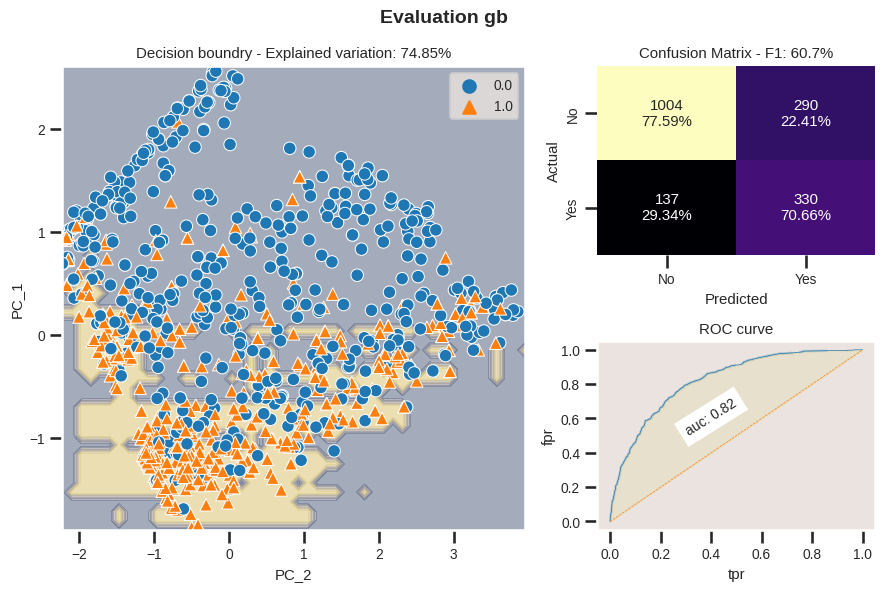

100%|██████████| 3/3 [01:00<00:00, 20.32s/it]


In [56]:
evaluate = EvaluateModels()
evaluate.evaluate_all(X_train1, y_train, X_test1, y_test)